# ONNX Pred

In [6]:
import torch
import cv2
import yaml
import ultralytics
from torchvision import transforms
import numpy as np
import yaml
import onnxruntime as ort

In [14]:
import os
os.getcwd()

'/Users/leoliu/Documents/meichu-2023/Model'

In [206]:
model_path = r'yolov8/yolov8n.onnx'
label_path = r'coco128.yaml'
image_path = ['classroom.jpg','car_person.jpg']
positive_list = [0,2]
confidence_thres = 0.5
iou_thres = 0.7


In [207]:
class YOLOv8inference:
    """YOLOv8 object detection model class for handling inference and visualization."""

    def __init__(self, onnx_model, input_image, confidence_thres, iou_thres,cocolabel_path,positive_list):
        """
        Initializes an instance of the YOLOv8 class.

        Args:
            onnx_model: Path to the ONNX model.
            input_image: Path to the input image.
            confidence_thres: Confidence threshold for filtering detections.
            iou_thres: IoU (Intersection over Union) threshold for non-maximum suppression.
        """
        
        self.onnx_model = onnx_model
        self.input_image = input_image
        self.confidence_thres = confidence_thres
        self.iou_thres = iou_thres
        self.cocolabel_path = cocolabel_path

        # Load the class names from the COCO dataset
        self.classes = self.yaml_load()['names']
        
        # Generate a color palette for the classes
        self.color_palette = np.random.uniform(0, 255, size=(len(self.classes), 3))
        self.positive_list = positive_list

    def draw_detections(self, img, box, score, class_id):
        """
        Draws bounding boxes and labels on the input image based on the detected objects.

        Args:
            img: The input image to draw detections on.
            box: Detected bounding box.
            score: Corresponding detection score.
            class_id: Class ID for the detected object.

        Returns:
            None
        """

        # Extract the coordinates of the bounding box
        x1, y1, w, h = box

        # Retrieve the color for the class ID
        color = self.color_palette[class_id]

        # Draw the bounding box on the image
        cv2.rectangle(img, (int(x1), int(y1)), (int(x1 + w), int(y1 + h)), color, 2)

        # Create the label text with class name and score
        label = f'{self.classes[class_id]}: {score:.2f}'

        # Calculate the dimensions of the label text
        (label_width, label_height), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)

        # Calculate the position of the label text
        label_x = x1
        label_y = y1 - 10 if y1 - 10 > label_height else y1 + 10

        # Draw a filled rectangle as the background for the label text
        cv2.rectangle(img, (label_x, label_y - label_height), (label_x + label_width, label_y + label_height), color,
                    cv2.FILLED)

        # Draw the label text on the image
        cv2.putText(img, label, (label_x, label_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

    def yaml_load(self):
        with open(self.cocolabel_path, 'r') as file:
            cfg = yaml.safe_load(file)
        return cfg
    
    def preprocess(self):
        """
        Preprocesses the input image before performing inference.

        Returns:
            image_data: Preprocessed image data ready for inference.
        """
        # Read the input image using OpenCV
        self.img = cv2.imread(self.input_image)

        # Get the height and width of the input image
        self.img_height, self.img_width = self.img.shape[:2]

        # Convert the image color space from BGR to RGB
        img = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)

        # Resize the image to match the input shape
        img = cv2.resize(img, (self.input_width, self.input_height))

        # Normalize the image data by dividing it by 255.0
        image_data = np.array(img) / 255.0

        # Transpose the image to have the channel dimension as the first dimension
        image_data = np.transpose(image_data, (2, 0, 1))  # Channel first

        # Expand the dimensions of the image data to match the expected input shape
        image_data = np.expand_dims(image_data, axis=0).astype(np.float32)

        # Return the preprocessed image data
        return image_data

    
    def postprocess(self, input_image, output):
        """
        Performs post-processing on the model's output to extract bounding boxes, scores, and class IDs.
        Args:
            input_image (numpy.ndarray): The input image.
            output (numpy.ndarray): The output of the model.

        Returns:
            numpy.ndarray: The input image with detections drawn on it.
        """

        # Transpose and squeeze the output to match the expected shape
        outputs = np.transpose(np.squeeze(output[0]))

        # Get the number of rows in the outputs array
        rows = outputs.shape[0]

        # Lists to store the bounding boxes, scores, and class IDs of the detections
        boxes = []
        scores = []
        class_ids = []
    
        # Calculate the scaling factors for the bounding box coordinates
        x_factor = self.img_width / self.input_width
        y_factor = self.img_height / self.input_height

        # Iterate over each row in the outputs array
        for i in range(rows):
            # Extract the class scores from the current row
            classes_scores = outputs[i][4:]

            # Find the maximum score among the class scores
            max_score = np.amax(classes_scores)

            # If the maximum score is above the confidence threshold
            if max_score >= self.confidence_thres:
                # Get the class ID with the highest score
                class_id = np.argmax(classes_scores)

                # Extract the bounding box coordinates from the current row
                x, y, w, h = outputs[i][0], outputs[i][1], outputs[i][2], outputs[i][3]

                # Calculate the scaled coordinates of the bounding box
                left = int((x - w / 2) * x_factor)
                top = int((y - h / 2) * y_factor)
                width = int(w * x_factor)
                height = int(h * y_factor)

                # Add the class ID, score, and box coordinates to the respective lists
                # and filter indices before NMS
                if class_id in self.positive_list:
                    class_ids.append(class_id)
                    scores.append(max_score)
                    boxes.append([left, top, width, height])

        # Apply non-maximum suppression to filter out overlapping bounding boxes
        indices = cv2.dnn.NMSBoxes(boxes, scores, self.confidence_thres, self.iou_thres)

        self.predresult = []
        # Iterate over the selected indices after non-maximum suppression
        for i in indices:
            # Get the box, score, and class ID corresponding to the index
            box = boxes[i]
            score = scores[i]
            class_id = class_ids[i]
            self.predresult.append((class_id,box,score))
            # Draw the detection on the input image
            self.draw_detections(input_image, box, score, class_id)

        # Return the modified input image
        return input_image

    def pred_result(self):
        return self.predresult
    
    def main(self):
        """
        Performs inference using an ONNX model and returns the output image with drawn detections.

        Returns:
            output_img: The output image with drawn detections.
        """
        # Create an inference session using the ONNX model and specify execution providers
        session = ort.InferenceSession(self.onnx_model, providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])

        # Get the model inputs
        model_inputs = session.get_inputs()

        # Store the shape of the input for later use
        input_shape = model_inputs[0].shape
        self.input_width = input_shape[2]
        self.input_height = input_shape[3]

        # Preprocess the image data
        img_data = self.preprocess()

        # Run inference using the preprocessed image data
        outputs = session.run(None, {model_inputs[0].name: img_data})
        print(outputs)
        # Perform post-processing on the outputs to obtain output image.
        return self.postprocess(self.img, outputs)  # output image



In [208]:
modelinfer = YOLOv8inference(
    onnx_model = model_path, 
    input_image = image_path[0], 
    confidence_thres = confidence_thres, 
    iou_thres = iou_thres,
    cocolabel_path = label_path,
    positive_list = positive_list)

In [209]:
result = modelinfer.main()

[array([[[      3.094,      13.431,      21.392, ...,       510.1,      515.07,      618.82],
        [      16.78,       6.109,      7.4743, ...,      582.34,      539.86,      527.98],
        [     6.2421,      22.494,      37.711, ...,      263.63,      266.62,      43.316],
        ...,
        [ 2.3842e-07,  1.4901e-07,  5.9605e-08, ...,  1.4901e-06,  1.1623e-06,  2.3246e-06],
        [ 1.7881e-07,  1.7881e-07,  1.1921e-07, ...,  2.5928e-06,  1.8477e-06,   2.861e-06],
        [ 4.4703e-07,  2.9802e-07,  1.7881e-07, ...,  3.1292e-06,  2.4438e-06,  5.0962e-06]]], dtype=float32)]


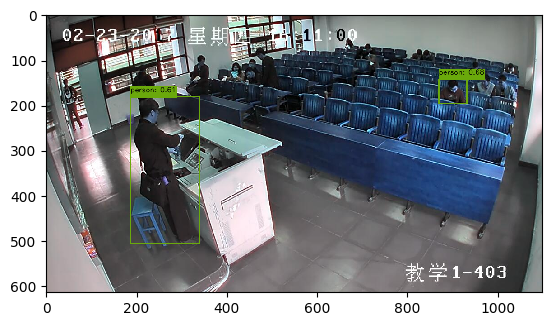

In [119]:
from matplotlib import pyplot as plt
plt.imshow(result, interpolation='nearest')
plt.show()

In [120]:
modelinfer2 = YOLOv8inference(
    onnx_model = model_path, 
    input_image = image_path[1], 
    confidence_thres = confidence_thres, 
    iou_thres = iou_thres,
    cocolabel_path = label_path,
    positive_list = positive_list)

In [121]:
result2 = modelinfer2.main()

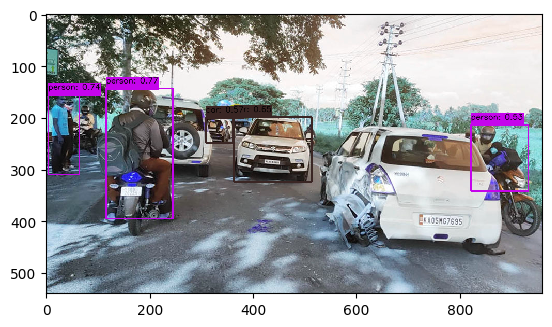

In [122]:
from matplotlib import pyplot as plt
plt.imshow(result2, interpolation='nearest')
plt.show()

In [127]:
predresult = modelinfer2.pred_result()

In [128]:
predresult 

[(0, [116, 145, 129, 251], 0.77295333),
 (0, [4, 157, 60, 154], 0.7435808),
 (2, [363, 200, 151, 125], 0.6498951),
 (2, [309, 201, 52, 49], 0.5696397),
 (0, [822, 215, 111, 128], 0.52751833)]